# Setup

In [0]:
! pip install transformers --quiet

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

# today's date
SEED = 20200420 

# Good practice for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Colab specfic setup

In [0]:
# You need to upload the files manually here....
files = ['Entity_sentiment_trainV2.xlsx', 'Entity_sentiment_testV2.xlsx', 'test_small.csv', 'Semeval2014_exact_train.csv', 
         'Semeval2014_exact_test.csv', 'Semeval2014_train.csv', 'Semeval2014_test.csv']

drive_path = '/content/drive/My Drive/Colab/data/'

for file in files:
    if not os.path.exists(file):
        if os.path.exists(drive_path):
            print(f'Copying {file}')
            ! cp '{drive_path}{file}' .
        else:
            if file != 'test_small.csv':
                raise Exception(f'You need to manually upload {file}')

# Data Prep / Utilities

In [0]:
def oversample_minority(df, target_col):
    # Not ideal way to oversample - using quick and dirty approach for an experiment with mixed sentiments (see below)
    max_size = df[target_col].value_counts().max()
    dfs = [df]
    for class_index, group in df.groupby(target_col):
        dfs.append(group.sample(max_size - len(group), replace=True))

    return pd.concat(dfs)

def accuracy_at_thresh(preds, labels, threshold=0.5):
    preds_binary = np.where(preds > threshold, 1, 0)
    accuracy = np.sum(preds_binary == labels) / len(labels)
    
    return accuracy * 100

def plot_prec_recall_vs_tresh(labels, preds):
    precisions, recalls,thresholds = precision_recall_curve(labels, preds)
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
    plt.show()

In [0]:
df_train = pd.read_excel('./Entity_sentiment_trainV2.xlsx')
df_test = pd.read_excel('./Entity_sentiment_testV2.xlsx')
df_test_small = pd.read_csv('./test_small.csv')

df_test['Sentiment'] = np.NaN

# The SemEval2014 data cleaned up in a format that works with the existing data
# 'exact' refers to a subset of the data where the Sentence contains the Entity - i.e. in the same format as train/test data
df_sem_exact_train = pd.read_csv('Semeval2014_exact_train.csv')
df_sem_exact_test = pd.read_csv('Semeval2014_exact_test.csv')
df_sem_train = pd.read_csv('Semeval2014_train.csv')
df_sem_test = pd.read_csv('Semeval2014_test.csv')

# Posing the Entity as a question as per QA-M in the paper https://arxiv.org/pdf/1903.09588.pdf

def add_qa_format(df):
    # Can be a bit slow using apply, but it's only a small dataset
    df['EntityQA'] = df.Entity.apply(lambda x: f'what do you think of the {x} of it?')

add_qa_format(df_train)
add_qa_format(df_test)
add_qa_format(df_test_small)
add_qa_format(df_sem_exact_train)
add_qa_format(df_sem_exact_test)
add_qa_format(df_sem_train)
add_qa_format(df_sem_test)

# Data where the classes are equal, for use below
df_train_bal = oversample_minority(df_train, 'Sentiment')

# Mixing sentiments to try and improve TABSA

In [0]:
# Mix together the positive and negative sentiments in the sentence data to make the TASBA harder
# This is a random concatenation and random order of positive and negative e.g.

# Sentence | Entity | Sentiment
# Axa had great customer service. <inserted negative sentiment>Axa was expensive<end> | service | positive

df_pos = df_train_bal.loc[df_train_bal.Sentiment == 'positive'].sample(frac=1).reset_index(drop=True)
df_neg = df_train_bal.loc[df_train_bal.Sentiment == 'negative'].sample(frac=1).reset_index(drop=True)

df_pos['SentMixed'] = np.where(
    np.random.random(len(df_pos)) > 0.5, 
    df_pos.Sentence.str.cat(df_neg.Sentence, sep=". "), 
    df_neg.Sentence.str.cat(df_pos.Sentence, sep=". ")
    )

# re-shuffle the data
df_neg = df_neg.sample(frac=1).reset_index(drop=True)

df_neg['SentMixed'] = np.where(
    np.random.random(len(df_pos)) > 0.5, 
    df_pos.Sentence.str.cat(df_neg.Sentence, sep=". "), 
    df_neg.Sentence.str.cat(df_pos.Sentence, sep=". ")
    )

# combine pos and neg
df_mixed = df_pos.append(df_neg).reset_index(drop=True)
# Remove any double full stops that were created by the joins
df_mixed.SentMixed = df_mixed.SentMixed.str.replace(r'\.+', '.')

# Also try a feature where the mixed sentiment is only applied half of the time
df_mixed['SentMixedRand'] = np.where(np.random.random(len(df_mixed)) > 0.5, df_mixed.SentMixed, df_mixed.Sentence)

# Training

In [0]:
# Combining both Logically and SemEval training data for an experiment
df_sem_exact_train['SentMixedRand'] = df_sem_exact_train.Sentence
df_train_all = df_sem_exact_train.append(df_mixed)

In [8]:
BS = 32
BS_EVAL = 32

# Trying out the different features to see which works best
# For all approaches I've used the Sentence-pair approach as it signficantly outperformed BERT Single in the paper

# Acronyms match those of the paper
### NLI-M
# features = list(zip(df_train.Sentence.values, df_train.Entity.values))
# labels = torch.tensor(np.where(df_train.Sentiment == 'positive', 1, 0))

### NLI-M - All mixed sentiment (not good)
# features = list(zip(df_mixed.SentMixed.values, df_mixed.Entity.values))
# labels = torch.tensor(np.where(df_mixed.Sentiment == 'positive', 1, 0))

### NLI-M - Half mixed sentiment
features = list(zip(df_mixed.SentMixedRand.values, df_mixed.Entity.values))
labels = torch.tensor(np.where(df_mixed.Sentiment == 'positive', 1, 0))

### QA-M - Half mixed sentiment
# features = list(zip(df_mixed.SentMixedRand.values, df_mixed.EntityQA.values))
# labels = torch.tensor(np.where(df_mixed.Sentiment == 'positive', 1, 0))

# Using huggingface transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# This handles the data prep e.g. lowercasing, tokenising, adding special tokens such as [CLS] [SEP]
features_dict = tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=features, # We're using pair
        add_special_tokens = True,
        pad_to_max_length = 'right',
        return_tensors = 'pt',
        return_token_type_ids=True,
        return_attention_masks=True)

development_ds = TensorDataset(
    features_dict['attention_mask'],
    features_dict['input_ids'],
    features_dict['token_type_ids'],
    labels)

# 80/20 split
val_size = len(development_ds) // 5
train_size = len(development_ds) - val_size

train_data, val_data = torch.utils.data.random_split(development_ds, [train_size, val_size])

print(f'Train size: {len(train_data)}')
print(f'Validation size: {len(val_data)}')

train_dl = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=BS)
val_dl = DataLoader(val_data, batch_size=BS_EVAL, shuffle=False)

Train size: 6560
Validation size: 1640



Epoch: 1 | Train Loss: 0.3426 | Val Loss: 0.23397 | Val AUC: 0.968




Epoch: 2 | Train Loss: 0.1514 | Val Loss: 0.18991 | Val AUC: 0.978




Epoch: 3 | Train Loss: 0.0912 | Val Loss: 0.1834 | Val AUC: 0.987




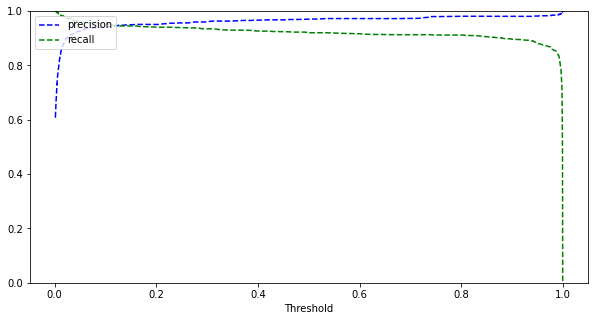

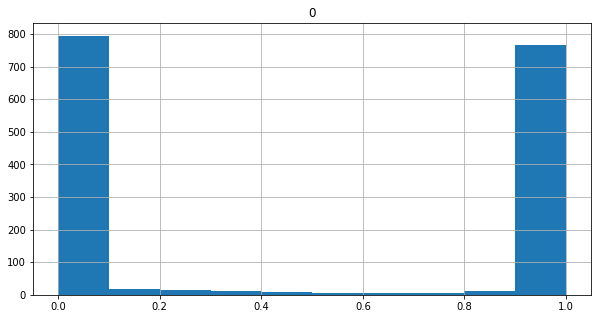

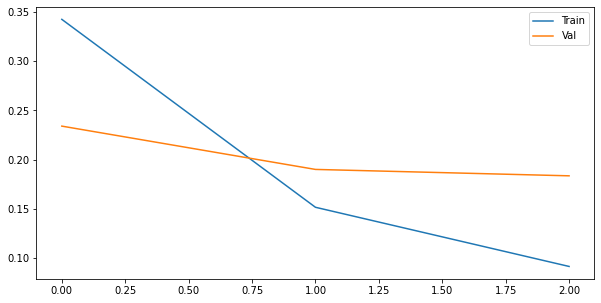

In [9]:
# Didn't have time for grid/random search of hyperparameters or k-fold CV. Did manual tuning of LR and EPOCHS
# Starting point for LR was 5e-5 as per the code from the paper https://github.com/HSLCY/ABSA-BERT-pair

LR = 5e-5
EPOCHS = 3

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

# Use AdamW with weight decay fix like the paper
optimizer = AdamW(model.parameters(), lr=LR)
losses = []

# Pretty standard PyTorch training loop
for epoch in tqdm(range(1, EPOCHS +1), desc="Epoch"):

    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(tqdm(train_dl, desc="Train Iter")):
        batch = tuple(t.to(device) for t in batch)
        attention_mask, input_ids, token_type_ids, label_ids = batch

        model.zero_grad()
        loss, logits = model(input_ids,
                             token_type_ids=token_type_ids,
                             attention_mask=attention_mask,
                             labels=label_ids)

        tr_loss += loss.item()
        loss.backward()
        # Not sure it's necessary, but they do this in the hugging face repo
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
    
    model.eval()
    val_loss = 0
    nb_val_steps, nb_val_examples = 0, 0
    tr_labels, tr_preds = None, None

    for step, batch in enumerate(val_dl):
        batch = tuple(t.to(device) for t in batch)
        attention_mask, input_ids, token_type_ids, label_ids = batch

        tmp_val_loss, logits = model(input_ids,
                             token_type_ids=token_type_ids,
                             attention_mask=attention_mask,
                             labels=label_ids)

        logits = F.softmax(logits, dim=-1)
        logits = logits.detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()

        # Not ideal collecting the performance data like this - would normally use Tensorboard
        tr_preds = logits[:, 1] if tr_preds is None else np.append(tr_preds, logits[:, 1])
        tr_labels = label_ids if tr_labels is None else np.append(tr_labels, label_ids)

        val_loss += tmp_val_loss.mean().item()
        nb_val_examples += input_ids.size(0)
        nb_val_steps += 1

    tr_loss = tr_loss / nb_tr_steps
    val_loss = val_loss / nb_val_steps
    auc = roc_auc_score(tr_labels, tr_preds)
    losses.append((tr_loss, val_loss))

    print(f'Epoch: {epoch} | Train Loss: {round(tr_loss,5)} | Val Loss: {round(val_loss, 5)} | Val AUC: {round(auc, 3)}\n')

plot_prec_recall_vs_tresh(tr_labels, tr_preds)
pd.DataFrame(tr_preds).hist()
pd.DataFrame(losses, columns=['Train', 'Val']).plot()

# Evaluate various indpendent datasets & Save Test Set Predictions

In [0]:
# Ignore
save_path = 'drive/My Drive/Colab/data/models/'

In [0]:
# torch.save(model.state_dict(), f'{save_path}NLIM-3.mod')

In [0]:
def eval(eval_df, model, qa=False, saved_model='', show_charts=False, acc_treshold=0.5, return_preds=False):

    if saved_model:
        model.load_state_dict(torch.load(f'{save_path}{saved_model}'))

    # Switches between question answering format and plain sentence pairs
    if qa or 'qa' in saved_model.lower():
        test_features = list(zip(eval_df.Sentence.values, eval_df.Entity.values))
    else:
        test_features = list(zip(eval_df.Sentence.values, eval_df.EntityQA.values))

    test_labels = torch.tensor(np.where(eval_df.Sentiment == 'positive', 1, 0))

    test_features_dict = tokenizer.batch_encode_plus(
            batch_text_or_text_pairs=test_features,
            add_special_tokens = True,
            pad_to_max_length = 'right',
            return_tensors = 'pt',
            return_token_type_ids=True,
            return_attention_masks=True)

    test_ds = TensorDataset(
        test_features_dict['attention_mask'],
        test_features_dict['input_ids'],
        test_features_dict['token_type_ids'],
        test_labels)

    test_dl = DataLoader(test_ds, batch_size=BS_EVAL, shuffle=False)

    t_labels, t_preds = None, None
    model.eval()

    for step, batch in enumerate(test_dl):
        batch = tuple(t.to(device) for t in batch)
        attention_mask, input_ids, token_type_ids, label_ids = batch

        logits = model(input_ids,
                       token_type_ids=token_type_ids,
                       attention_mask=attention_mask)

        logits = F.softmax(logits[0], dim=-1)
        logits = logits.detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()
        t_preds = logits[:, 1] if t_preds is None else np.append(t_preds, logits[:, 1])
        t_labels = label_ids if t_labels is None else np.append(t_labels, label_ids)


    if return_preds:
        return t_preds

    auc = roc_auc_score(t_labels, t_preds)
    acc = accuracy_at_thresh(t_preds, t_labels, acc_treshold)

    if not saved_model:
        saved_model = 'current'
    print(f'Model: {saved_model.ljust(25)} | AUC: {str(round(auc, 2)).ljust(4)} | Accuracy @ {acc_treshold}: {round(acc, 1)}')

    if show_charts:
        plot_prec_recall_vs_tresh(t_labels, t_preds)
        pd.DataFrame(t_preds).hist()

Model: current                   | AUC: 0.95 | Accuracy @ 0.5: 90.7
Model: current                   | AUC: 0.74 | Accuracy @ 0.5: 62.1


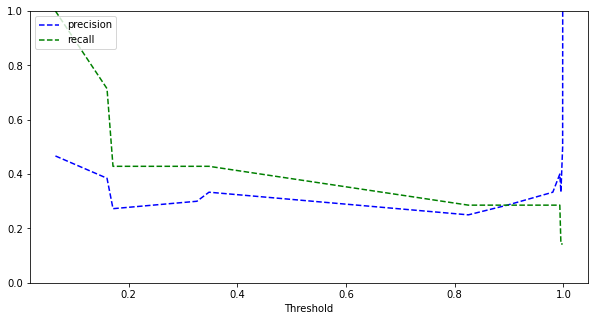

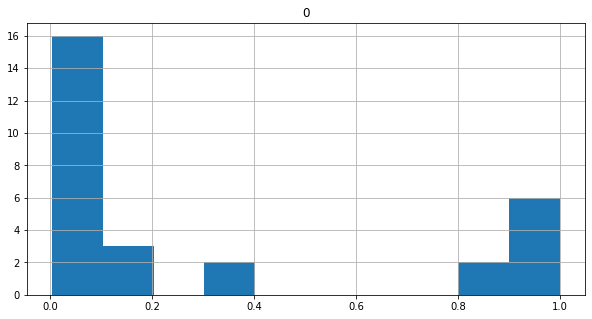

In [13]:
# There's no representative data to test, so I'm checking a couple of other datasets to get a game on out of distribution data
# First the SemEval test set. As you can see we nearly match the paper (though limited it to 'exact' examples like the training data)
eval(df_sem_exact_test, model)
# The second is a set of 30 hand labeled samples from the test data. In particular I pulled out some ones with opposing sentiment
eval(df_test_small, model, show_charts=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ce340bda0>]],
      dtype=object)

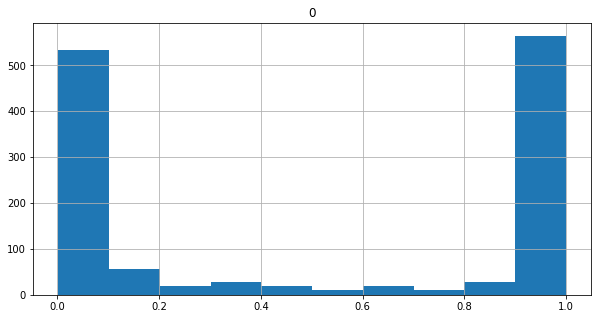

In [14]:
 # predictions on the test set look confident which seems promising
test_preds = eval(df_test, model, return_preds=True)
pd.DataFrame(test_preds).hist()

In [0]:
df_results = df_test.copy()
df_results['Probability'] = test_preds
df_results['Sentiment'] = np.where(df_results.Probability > 0.5, 'positive', 'negative')
df_results[['Sentence', 'Entity', 'Sentiment', 'Probability']].to_csv('Entity_sentiment_testV2_Results.csv', index=False)

# Evaluate previous saved models

Final choice of model was 'NLIMSentMixed-3.mod' - which is the pseudo question approach, but where half of the training data had opposing sentiment added from elsewhere in the trainng data. This performed well across all datasets, plus the distribution of the model probabilities was confident and nicely aligned.

In [16]:
if os.path.exists(save_path):
    for saved_model in sorted(os.listdir(save_path)):
        eval(df_sem_test, model, saved_model=saved_model)

Model: NLIM-2.mod                | AUC: 0.94 | Accuracy @ 0.5: 87.8
Model: NLIM-3.mod                | AUC: 0.94 | Accuracy @ 0.5: 88.4
Model: NLIMSentMixed-2.mod       | AUC: 0.43 | Accuracy @ 0.5: 43.0
Model: NLIMSentMixed-3.mod       | AUC: 0.92 | Accuracy @ 0.5: 86.6
Model: NLIMSentMixedRand-2.mod   | AUC: 0.93 | Accuracy @ 0.5: 87.8
Model: NLIMsentmixed4.mod        | AUC: 0.9  | Accuracy @ 0.5: 84.9
Model: QASentMixed-2.mod         | AUC: 0.92 | Accuracy @ 0.5: 78.3
Model: QASentMixed-3.mod         | AUC: 0.84 | Accuracy @ 0.5: 81.7
Model: QASentMixedFlipped-3.mod  | AUC: 0.92 | Accuracy @ 0.5: 82.3
Model: QASentMixedFlipped-8.mod  | AUC: 0.91 | Accuracy @ 0.5: 84.4
Model: QASentMixedSemEval-2.mod  | AUC: 0.91 | Accuracy @ 0.5: 84.2
Model: QASentMixedSemEval-3.mod  | AUC: 0.91 | Accuracy @ 0.5: 84.4
Model: QASentMixedSemEval-5.mod  | AUC: 0.83 | Accuracy @ 0.5: 78.6


In [17]:
if os.path.exists(save_path):
    for saved_model in sorted(os.listdir(save_path)):
        eval(df_test_small, model, saved_model=saved_model)

Model: NLIM-2.mod                | AUC: 0.76 | Accuracy @ 0.5: 58.6
Model: NLIM-3.mod                | AUC: 0.54 | Accuracy @ 0.5: 48.3
Model: NLIMSentMixed-2.mod       | AUC: 0.53 | Accuracy @ 0.5: 27.6
Model: NLIMSentMixed-3.mod       | AUC: 0.74 | Accuracy @ 0.5: 62.1
Model: NLIMSentMixedRand-2.mod   | AUC: 0.74 | Accuracy @ 0.5: 62.1
Model: NLIMsentmixed4.mod        | AUC: 0.63 | Accuracy @ 0.5: 65.5
Model: QASentMixed-2.mod         | AUC: 0.26 | Accuracy @ 0.5: 55.2
Model: QASentMixed-3.mod         | AUC: 0.68 | Accuracy @ 0.5: 55.2
Model: QASentMixedFlipped-3.mod  | AUC: 0.62 | Accuracy @ 0.5: 58.6
Model: QASentMixedFlipped-8.mod  | AUC: 0.43 | Accuracy @ 0.5: 41.4
Model: QASentMixedSemEval-2.mod  | AUC: 0.65 | Accuracy @ 0.5: 55.2
Model: QASentMixedSemEval-3.mod  | AUC: 0.43 | Accuracy @ 0.5: 41.4
Model: QASentMixedSemEval-5.mod  | AUC: 0.82 | Accuracy @ 0.5: 69.0


# Data exploration

In [18]:
df_train.head()

,Sentence,Entity,Sentiment,EntityQA
0,The website was very easy to use and my insura...,website,positive,what do you think of the website of it?
1,The web sight was easy to understand and I got...,web sight,positive,what do you think of the web sight of it?
2,Having filled in the application on-line I cou...,point,negative,what do you think of the point of it?
3,After finding AXA was cheaper than my renewal ...,prices,positive,what do you think of the prices of it?
4,The quote was a reasonable price compared with...,insurances,positive,what do you think of the insurances of it?


In [19]:
train_ents = df_train.Entity.unique()
test_ents = df_test.Entity.unique()

print(f'Train entities: {len(train_ents)}')
print(f'Test entities: {len(test_ents)}')
print(f'Intersection: {len(set(train_ents) & set(test_ents))}')

Train entities: 748
Test entities: 255
Intersection: 205


Need to consider calibration - probably best to align it with the balance of the training data

In [20]:
pct_pos = (df_train.Sentiment.value_counts() [0] / len(df_train)) * 100
print(f'Class balance: {round(pct_pos)} % are postive sentiment')

Class balance: 68.0 % are postive sentiment
